# Introduction
This notebook calculates pValues for the independant variables via bootstrapping.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [2]:
useRaw=False

outdir = 'pvals'
filename='pvals'
os.makedirs(outdir, exist_ok=True)

# the dependant variable(s)
columns_dep_var= ['cc.TrumpGEVote','cc.TrumpPVote', 'cc.vote12.gop']

#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

# Choose which dependant variable to operate on

In [3]:
dep_var = columns_dep_var[2]
dump_these_dep_var_columns=columns_dep_var.copy()
dump_these_dep_var_columns.remove(dep_var)
dep_var

'cc.vote12.gop'

## Get the columns of interest, including all dependent vars

In [4]:
all = pd.read_excel('./data/CCESplusVariables.xlsx',encoding = "ISO-8859-1")

# for every regid=3.1 get the third column (variable name) convert to a list
columns = list(all[ (all['regid']==1.1) & (all['exclude']!='t')  ].iloc[:,2])

# #strip dependant variables
# columns = [col for col in columns if col not in columns_dep_var]
# columns

In [5]:
#WARNING! 'cc.i.white.educhs not in df! No worries though 
#its correlated with composed of cc.maxeduc.hs and cc.WhiteDum
#so drop it
columns.remove('cc.i.white.educhs')

In [6]:
len(columns)
# columns

35

## Extract just those columns from orig dataframe

In [7]:
df = df[columns]

In [8]:
len(df.columns)

35

## Remove NaN dependent variable rows


In [9]:
def remove_dep_var_nan_rows(df, col_dep_var, dump_these_dep_var_columns ,silent = False):
    """
    parse df into rows where df.col_dep_var does not have NaNs, 
    df: dataframe to pull NaN rows out of
    col_dep_var: dependent variable
    dump_these_dep_var_columns: other dep_var columns that may be highly correlated with dep var
    """
    dftmp= df.copy()
    
    if(silent is False):
        print(f'dropping {(pd.isnull(dftmp[col_dep_var])).sum()} rows where {col_dep_var}=NaN')
                      
    #dump the NaN rows
    dftmp = dftmp[pd.notnull(dftmp[col_dep_var] )]
    
    #dump the dump_these_dep_var_columns
    dftmp.drop(dump_these_dep_var_columns,axis=1,inplace=True);
    
    return dftmp

# pull out the nulls from the column of interest
dftmp= remove_dep_var_nan_rows(df, columns_dep_var[0],dump_these_dep_var_columns )

dropping 23710 rows where cc.TrumpGEVote=NaN


In [10]:
#get a list of the columns to operate on minus the dependant variable
columns = dftmp.columns.drop(dep_var)
columns

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

## Split out categorical and continuous variables
see if fastai can auto do it

In [11]:
# #give fastai a shot at splitting cat and cont variables
res_cont, res_cat = cont_cat_split(dftmp,max_card=18)

## Categorify and Fill Missing

In [12]:
#from docs https://docs.fast.ai/tabular.transform.html
# tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
# tfm(dftmp)

In [13]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(dftmp)

## Generate train and test set

In [14]:
# split out train/test sets
from sklearn.model_selection import train_test_split

trn=tst=None
trn,tst = train_test_split(dftmp, test_size=0.1)
print(str(len(trn)))
print(str(len(tst)))

36801
4089


In [15]:
len(trn.columns)

33

In [16]:
#split out trn_y and tst_y
#this is the dep_var, converted to an int
trn_y = trn[dep_var].copy()
tst_y = tst[dep_var].copy()
trn_y.astype('int64');
trn_y.astype('int64');

trn.drop(dep_var,axis=1,inplace=True);
tst.drop(dep_var,axis=1,inplace=True);

# Lets get the predictions on valid data

In [17]:
import pvals as pv

In [18]:
# #get something small to train on
# NUMBERSAMPS = 1000
# trn_sm = trn[:NUMBERSAMPS]
# trn_sm_y= trn_y[:NUMBERSAMPS]
# tst_sm = tst[:NUMBERSAMPS]
# tst_sm_y = tst[:NUMBERSAMPS]
# columns=['cc.raceviewsum']

# len(trn_sm),len(trn_sm_y),len(tst_sm) 
# columns = ['cc.raceviewsum', 'cc.CC16_307']

In [19]:
NUMBERITERATIONS=500
res = pv.get_all_pvals(columns,trn,trn_y,tst,NUMBERITERATIONS )


correct get_AME for column cc.emp.nojob is 0.0
get permuted get_AME for column cc.emp.nojob
...........................................................................................

correct get_AME for column cc.faminc is -0.010801025262984765
get permuted get_AME for column cc.faminc
..................................................

correct get_AME for column crashpc is 0.0013479136580347717
get permuted get_AME for column crashpc
..................................................

correct get_AME for column rustpc is 0.0031629950837422927
get permuted get_AME for column rustpc
..................................................

correct get_AME for column job.uer is 0.0016896961064124527
get permuted get_AME for column job.uer
..................................................

correct get_AME for column econ.mhi is -0.0008119874697497531
get permuted get_AME for column econ.mhi
..................................................

correct get_AME for column econ.hhpov.p is 0.0020

# Save, print and plot 

In [20]:
# save this info to disk
pickle.dump(res, open(outdir+"/"+filename, 'wb'))

In [21]:
# load the model from disk
res = pickle.load(open(outdir+"/"+filename, 'rb'))

# res[0].correct_pred, res[0].permuted_preds
# res[0].get_pval()

In [22]:
#print it
for item in res:
    print(f'Column {item.col}, p-value={item.get_pval()}')

Column cc.emp.nojob, p-value=0.03
Column cc.CC16_304, p-value=0.0
Column cc.faminc, p-value=0.0
Column crashpc, p-value=0.0
Column rustpc, p-value=0.0
Column job.uer, p-value=0.002
Column econ.mhi, p-value=0.216
Column econ.hhpov.p, p-value=0.176
Column taa.wrks.disc95.pcpy, p-value=0.0
Column cc.CC16_305_2, p-value=0.046
Column mort.ucd.despair.disc95.pdpy, p-value=0.0
Column cc.immviewsum, p-value=0.0
Column cc.raceviewsum, p-value=0.0
Column cc.CC16_307, p-value=0.0
Column cc.CC16_351B, p-value=0.044
Column cc.Age, p-value=0.0
Column cc.Sex, p-value=0.03
Column cc.BlackDum, p-value=0.058
Column cc.WhiteDum, p-value=0.048
Column cc.maxeduc.4yr, p-value=0.048
Column cc.maxeduc.hs, p-value=0.052
Column cc.isimmigrant, p-value=0.052
Column cc.child18, p-value=0.07
Column cc.union, p-value=0.056
Column cc.newsint, p-value=0.0
Column cc.Ideo7, p-value=0.0
Column cc.EvanProt, p-value=0.046
Column cc.Catholic, p-value=0.04
Column cc.Religiosity, p-value=0.0
Column demo.popdense, p-value=0.0

In [59]:
len(columns)

32

--- line is not-permted calc, others are permuted calcs


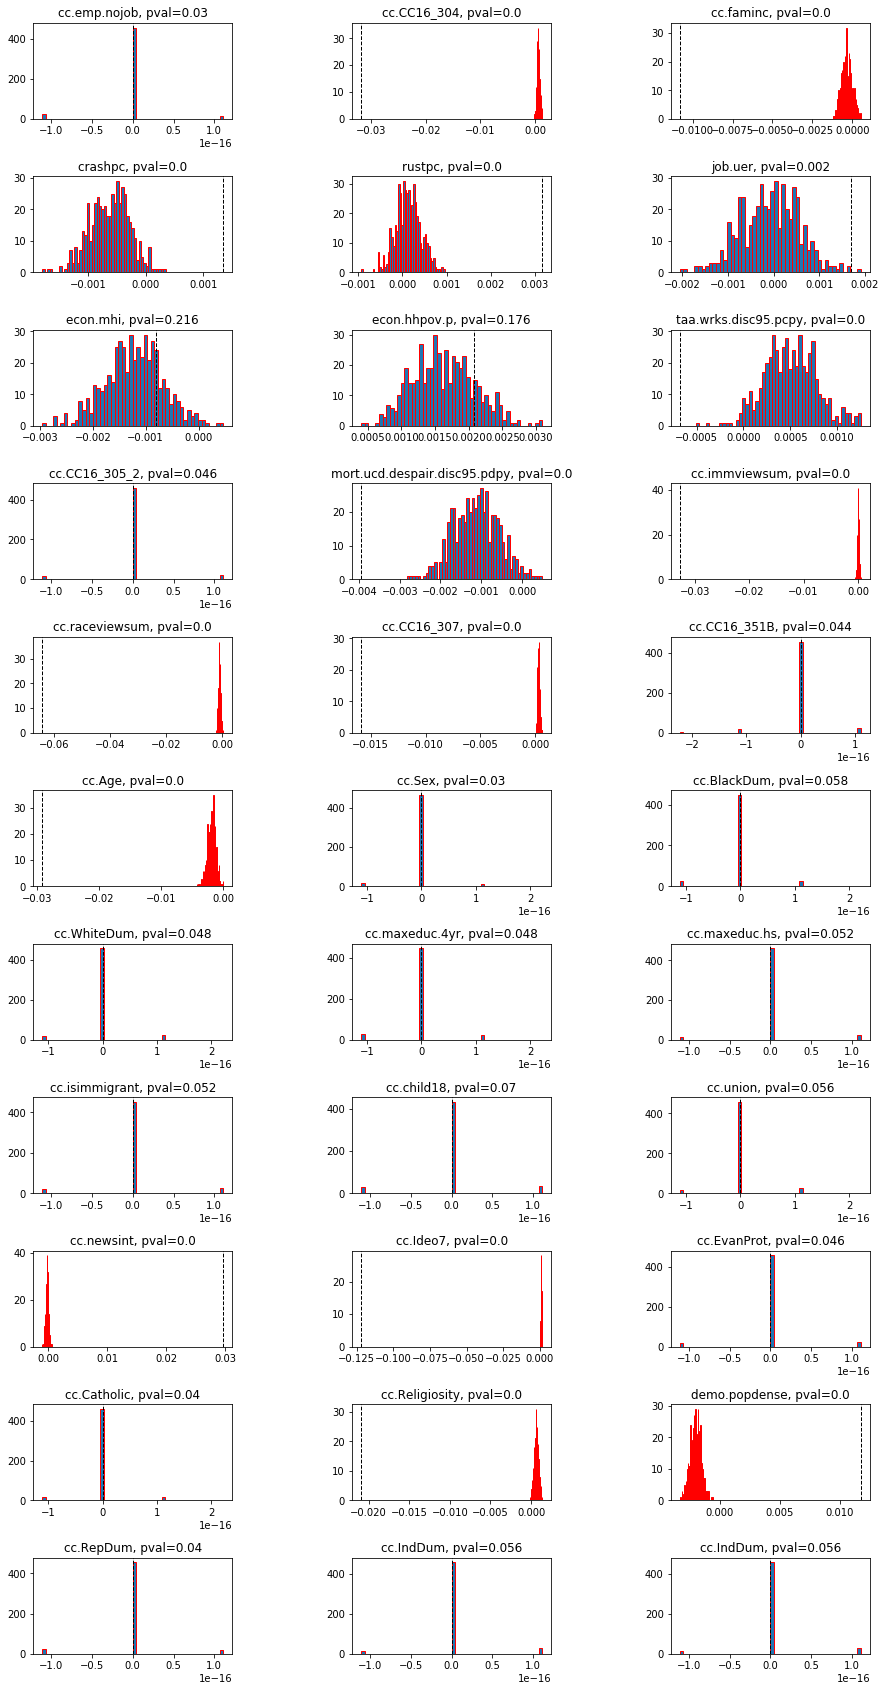

In [61]:
def draw_histograms(res, variables, n_rows, n_cols):
    fig, ax=plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(15,30) )
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    for i in range(n_rows):
        for j in range(n_cols):
            try:
                tmp = res[((i)*n_cols)+j]
            except:
                pass
                
            ax[i,j].set_title(f'{tmp.col}, pval={tmp.get_pval()}')
            ax[i,j].hist(tmp.permuted_preds,bins= 50,ec='red', label='permuted')
            ax[i,j].axvline(tmp.correct_pred, color='k', linestyle='dashed', linewidth=1, label='not-permuted')
    plt.show()

print ("--- line is not-permuted calc, others are permuted calcs")
draw_histograms(res, columns, 11,3)